In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
dataset = MNIST(root='data/', download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.96MB/s]


In [4]:
len(dataset)

60000

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

label: 5


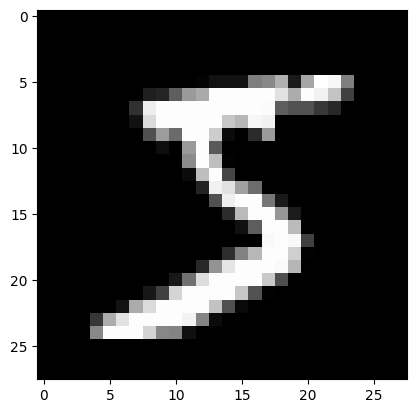

In [7]:
image, label = dataset[0]
plt.imshow(image , cmap='gray')
print('label:', label)

In [8]:
import torchvision.transforms as transforms

In [9]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0]
print(img_tensor.shape)
print(label)

torch.Size([1, 28, 28])
5


In [11]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


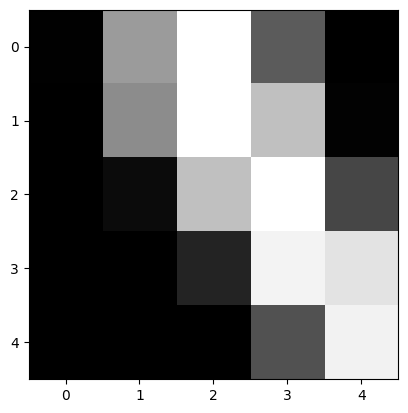

In [12]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

In [13]:
from torch.utils.data import random_split

train_ds,val_ds = random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

In [14]:
from torch.utils.data import DataLoader

batch_size=128

train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)



In [15]:
import torch.nn as nn

input_size=28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [16]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-1.3726e-02,  1.1372e-02,  5.7998e-03,  ...,  2.8040e-04,
          3.0324e-02, -7.6490e-03],
        [ 5.5929e-03, -1.3693e-02,  9.8603e-03,  ...,  6.6537e-04,
         -2.1128e-02, -1.8092e-02],
        [-9.3051e-03,  2.7534e-02, -2.3737e-03,  ..., -7.7746e-05,
         -2.4449e-02, -2.6572e-02],
        ...,
        [ 1.7452e-02,  1.7240e-02, -2.5302e-02,  ...,  2.4795e-02,
         -1.1846e-02, -2.7915e-02],
        [ 1.5068e-03,  7.9585e-03, -3.3886e-02,  ...,  1.6970e-02,
         -2.0417e-02,  1.1408e-02],
        [-2.4627e-02,  7.3712e-03,  2.6987e-02,  ...,  1.0187e-02,
          2.2666e-02,  1.6524e-02]], requires_grad=True)

In [17]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0038, -0.0056,  0.0095, -0.0066,  0.0315,  0.0325, -0.0135, -0.0333,
        -0.0344,  0.0177], requires_grad=True)

In [19]:
images.reshape(128,784).shape

torch.Size([128, 784])

In [20]:
class MnistModel(nn.Module):
  def __init__(self):
     super().__init__()
     self.linear = nn.Linear(input_size, num_classes)

  def forward(self,xb):
       xb = xb.reshape(-1,784)
       out = self.linear(xb)
       return out

model = MnistModel()


In [21]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [22]:
for images, labels in train_loader:
   outputs = model(images)
   break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0211, -0.2107,  0.3467,  0.2337, -0.0158, -0.3682, -0.1462,  0.3078,
         -0.1017, -0.0134],
        [-0.3434, -0.2334,  0.3237,  0.0786,  0.1698, -0.1128,  0.4259,  0.4470,
         -0.0327,  0.0092]])


In [23]:
import torch.nn.functional as F

In [24]:
outputs[:2]

tensor([[-0.0211, -0.2107,  0.3467,  0.2337, -0.0158, -0.3682, -0.1462,  0.3078,
         -0.1017, -0.0134],
        [-0.3434, -0.2334,  0.3237,  0.0786,  0.1698, -0.1128,  0.4259,  0.4470,
         -0.0327,  0.0092]], grad_fn=<SliceBackward0>)

In [25]:
probs = F.softmax(outputs, dim=1)

print("Sample probabilities:\n", probs[:2].data)

print("Sum: " , torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0955, 0.0790, 0.1379, 0.1232, 0.0960, 0.0675, 0.0842, 0.1326, 0.0881,
         0.0962],
        [0.0638, 0.0712, 0.1244, 0.0973, 0.1066, 0.0804, 0.1377, 0.1407, 0.0871,
         0.0908]])
Sum:  1.0000001192092896


In [26]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([2, 7, 7, 7, 7, 2, 2, 2, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 2, 6, 7, 3, 7, 7,
        7, 7, 7, 2, 7, 7, 2, 2, 4, 7, 7, 7, 6, 7, 7, 2, 7, 7, 2, 2, 2, 7, 7, 7,
        7, 6, 7, 7, 7, 7, 7, 7, 4, 2, 7, 7, 6, 7, 7, 3, 2, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 6, 7, 3, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 2, 7, 6, 4, 7, 7, 7, 6, 7, 7, 4, 1, 7, 7, 7, 3, 7, 2, 2, 7,
        4, 7, 4, 2, 7, 7, 4, 7])
tensor([0.1379, 0.1407, 0.1446, 0.1499, 0.1217, 0.1310, 0.1223, 0.1298, 0.1861,
        0.1261, 0.1421, 0.1332, 0.1452, 0.1267, 0.1186, 0.1363, 0.1467, 0.1355,
        0.1526, 0.1433, 0.1630, 0.1313, 0.1588, 0.1150, 0.1189, 0.1382, 0.1511,
        0.1398, 0.1350, 0.1282, 0.1277, 0.1317, 0.1301, 0.1691, 0.1438, 0.1759,
        0.1448, 0.1234, 0.1676, 0.1280, 0.1455, 0.1445, 0.1202, 0.1371, 0.1454,
        0.1077, 0.1273, 0.1658, 0.1453, 0.1348, 0.1739, 0.1511, 0.1659, 0.1320,
        0.1178, 0.1622, 0.1387, 0.1390, 0.1423, 0.1817, 0.1357, 0.1565, 0.1538,
       

In [27]:
labels

tensor([2, 4, 3, 1, 4, 5, 4, 6, 3, 2, 3, 2, 9, 7, 1, 6, 7, 5, 2, 7, 0, 2, 3, 1,
        2, 6, 6, 6, 7, 1, 6, 2, 9, 0, 3, 8, 7, 1, 0, 8, 7, 5, 8, 2, 6, 1, 1, 6,
        6, 9, 3, 5, 3, 2, 4, 3, 6, 6, 1, 2, 9, 9, 7, 9, 2, 5, 9, 7, 8, 8, 7, 6,
        7, 2, 2, 9, 7, 9, 0, 4, 8, 0, 0, 4, 1, 8, 1, 2, 1, 7, 4, 0, 8, 6, 5, 7,
        3, 9, 9, 9, 2, 2, 3, 2, 5, 3, 3, 9, 5, 3, 4, 1, 9, 3, 2, 5, 1, 6, 5, 5,
        6, 7, 2, 8, 9, 5, 8, 8])

In [28]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [29]:
accuracy(outputs , labels)

tensor(0.1406)

In [30]:
loss_fn = F.cross_entropy

In [31]:
loss = loss_fn(outputs,labels)
print(loss)

tensor(2.2862, grad_fn=<NllLossBackward0>)


In [32]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [33]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []

    for epoch in range(epochs):

        #training phase

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [34]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                         # Generate predictions
        loss = F.cross_entropy(out, labels)        # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                         # Generate predictions
        loss = F.cross_entropy(out, labels)        # Calculate loss
        acc = accuracy(out, labels)                # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()      # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()         # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [39]:
result0 = evaluate(model, val_loader)

In [35]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9657, val_acc: 0.5914
Epoch [1], val_loss: 1.6907, val_acc: 0.7272
Epoch [2], val_loss: 1.4854, val_acc: 0.7613
Epoch [3], val_loss: 1.3303, val_acc: 0.7838
Epoch [4], val_loss: 1.2111, val_acc: 0.8011


In [36]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1176, val_acc: 0.8112
Epoch [1], val_loss: 1.0425, val_acc: 0.8185
Epoch [2], val_loss: 0.9812, val_acc: 0.8236
Epoch [3], val_loss: 0.9302, val_acc: 0.8297
Epoch [4], val_loss: 0.8872, val_acc: 0.8337


In [37]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8503, val_acc: 0.8367
Epoch [1], val_loss: 0.8184, val_acc: 0.8396
Epoch [2], val_loss: 0.7905, val_acc: 0.8432
Epoch [3], val_loss: 0.7659, val_acc: 0.8448
Epoch [4], val_loss: 0.7439, val_acc: 0.8463


In [38]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7243, val_acc: 0.8482
Epoch [1], val_loss: 0.7065, val_acc: 0.8509
Epoch [2], val_loss: 0.6904, val_acc: 0.8530
Epoch [3], val_loss: 0.6757, val_acc: 0.8553
Epoch [4], val_loss: 0.6623, val_acc: 0.8570


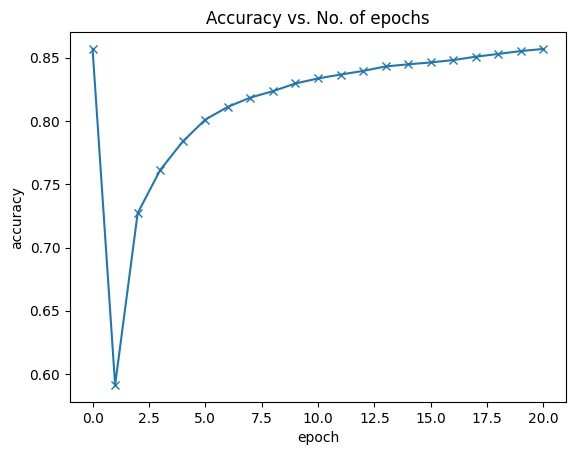

In [40]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');


In [41]:
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


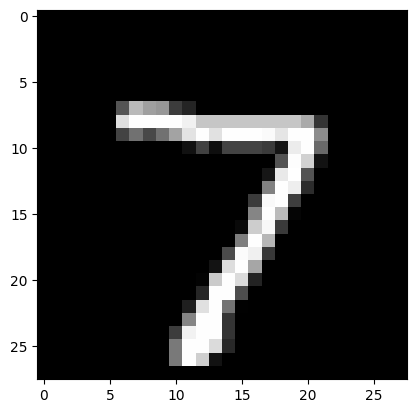

In [42]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)


In [44]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [45]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7  Predicted: 7


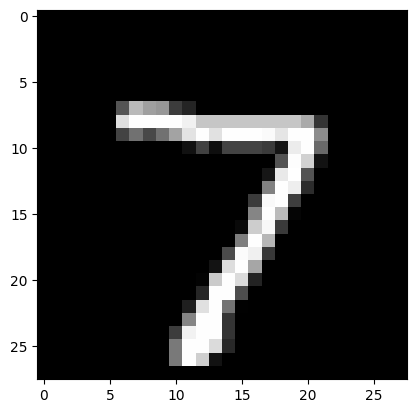

In [46]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ' Predicted:', predict_image(img, model))

Label: 0  Predicted: 0


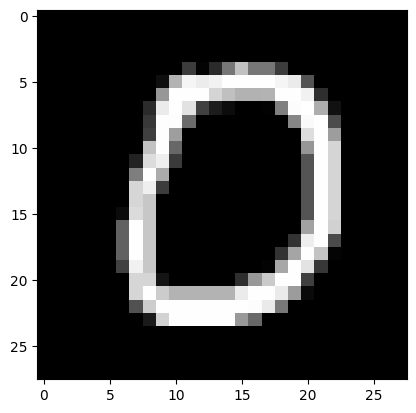

In [47]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ' Predicted:', predict_image(img, model))

Label: 9  Predicted: 9


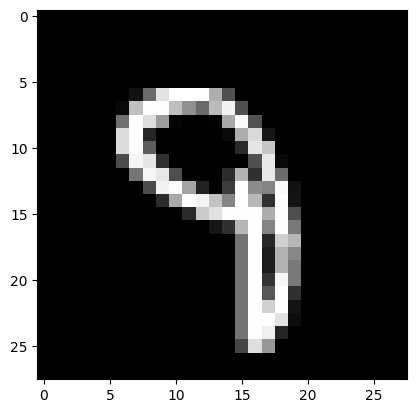

In [48]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ' Predicted:', predict_image(img, model))

Label: 2  Predicted: 8


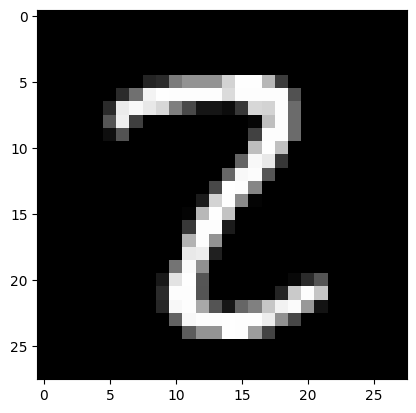

In [49]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ' Predicted:', predict_image(img, model))

In [50]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6414827108383179, 'val_acc': 0.859179675579071}

In [51]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [52]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0125, -0.0249, -0.0159,  ..., -0.0013,  0.0300, -0.0229],
                      [-0.0126,  0.0207,  0.0301,  ...,  0.0103,  0.0279,  0.0122],
                      [-0.0093, -0.0188,  0.0296,  ...,  0.0207,  0.0010,  0.0194],
                      ...,
                      [-0.0343,  0.0186,  0.0162,  ...,  0.0213,  0.0306,  0.0135],
                      [-0.0341,  0.0263,  0.0280,  ..., -0.0011,  0.0014, -0.0206],
                      [-0.0176,  0.0347,  0.0235,  ...,  0.0156,  0.0309, -0.0096]])),
             ('linear.bias',
              tensor([-0.0250,  0.0876,  0.0080, -0.0284,  0.0320,  0.0292,  0.0196,  0.0144,
                      -0.0791, -0.0377]))])

In [53]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0125, -0.0249, -0.0159,  ..., -0.0013,  0.0300, -0.0229],
                      [-0.0126,  0.0207,  0.0301,  ...,  0.0103,  0.0279,  0.0122],
                      [-0.0093, -0.0188,  0.0296,  ...,  0.0207,  0.0010,  0.0194],
                      ...,
                      [-0.0343,  0.0186,  0.0162,  ...,  0.0213,  0.0306,  0.0135],
                      [-0.0341,  0.0263,  0.0280,  ..., -0.0011,  0.0014, -0.0206],
                      [-0.0176,  0.0347,  0.0235,  ...,  0.0156,  0.0309, -0.0096]])),
             ('linear.bias',
              tensor([-0.0250,  0.0876,  0.0080, -0.0284,  0.0320,  0.0292,  0.0196,  0.0144,
                      -0.0791, -0.0377]))])

In [54]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6414827108383179, 'val_acc': 0.859179675579071}

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [58]:
import numpy as np

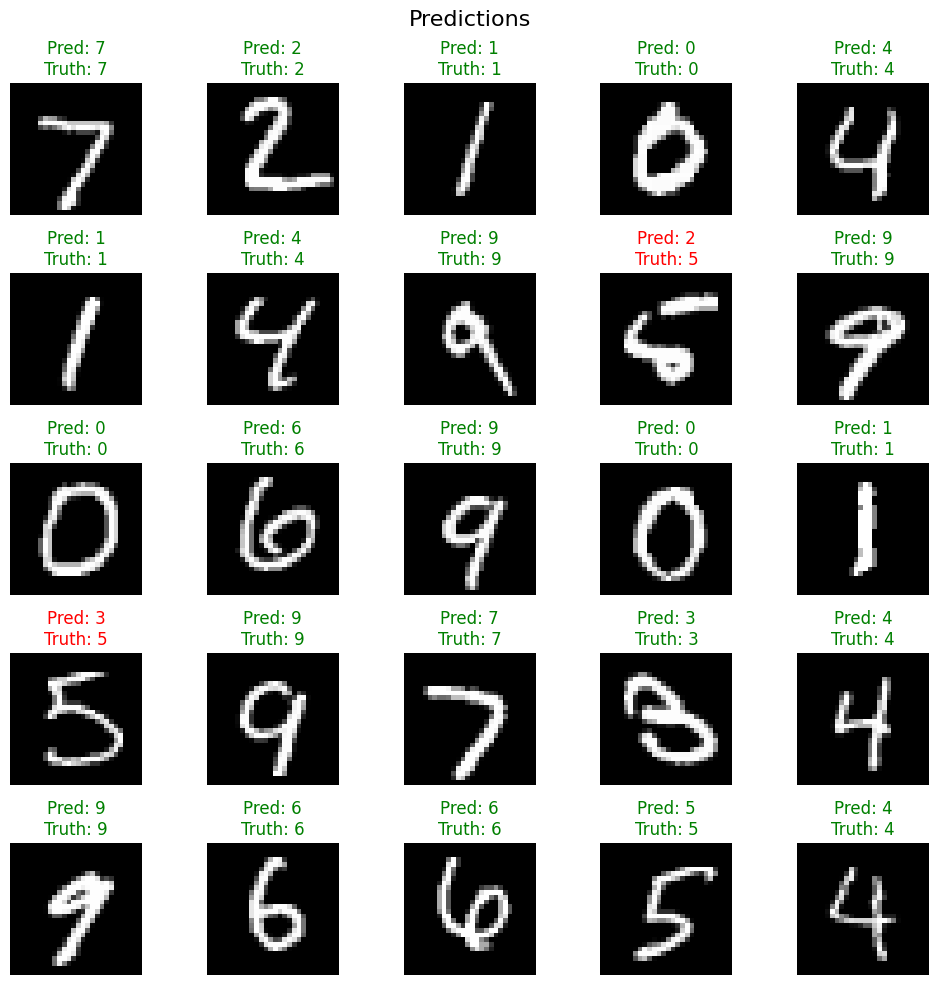

In [59]:
model.eval()


images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)


with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
    ax.axis('off')

    true_label = labels[i].item()
    predicted_label = predicted[i].item()

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(f'Pred: {predicted_label}\nTruth: {true_label}', color=color)

plt.tight_layout()
plt.show()